# CarGuardians: Master Analysis Pipeline & Report

## 1. Executive Summary
**Objective:** Predict Air Pressure System (APS) failures in Scania trucks to minimize maintenance costs.
**Key Challenge:** The cost of a missed failure (False Negative) is 50x higher than an unnecessary check (False Positive).
**Methodology:** 
1.  **Cost-Sensitive Learning:** LightGBM with custom objective functions.
2.  **Advanced Causal Modeling:** Sparse Bayesian Networks (PyMC) to identify root causes.
3.  **The Grand Unification:** A consensus approach combining K-S Tests, SHAP values, and Lasso Regression to find the true drivers of failure.

## 2. Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Project Imports
from challenge.data.ingest import load_data
from challenge.data.feature_selection import (
    select_features_ks, 
    select_features_mutual_info, 
    create_engineered_feature_set
)
from challenge.modelling.train_eval import evaluate_on_test
from challenge.modelling.experiment import run_experiment_grid
from challenge.modelling.models import get_models
from challenge.visualization.performance_viz import plot_experiment_results, plot_confusion, plot_cost_threshold_curve

# Visualization & Analysis Imports
from challenge.visualization.eda_plots import eda_plots_with_stats
from challenge.analysis.pca_analysis import pca_inspect, inspect_pca_loadings
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.data.preprocess import ScaniaPreprocessor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")

DATA_PATH = 'dataset/'
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'

# RCA Package Imports
from challenge.rca import (
    get_consensus_features,
    run_pc_algorithm,
    run_lingam_algorithm,
    analyze_graph_structure,
    run_pymc,
    visualize_hierarchy_final,
)


## 3. Data Ingestion & Initial Cleaning
We load the raw data and perform minimal cleaning (dropping low-NA rows and known outliers).

In [4]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

# Initial Cleaning: Drop rows with missing values in low-NA columns
na_pct = X_train_raw.isna().mean()
low_na_cols = na_pct[(na_pct > 0) & (na_pct <= 0.04)].index

if not low_na_cols.empty:
    rows_to_drop = X_train_raw[low_na_cols].isna().any(axis=1)
    drop_indices = X_train_raw[rows_to_drop].index
    
    X_train_raw = X_train_raw.drop(index=drop_indices)
    y_train_raw = y_train_raw.drop(index=drop_indices)
    print(f"Dropped {len(drop_indices)} rows based on low-NA columns.")

# Specific Outlier Removal (Identified via PCA)
# This observation has Z-scores > 100 on multiple features, indicating sensor error
outlier_idx_to_drop = 20683
if outlier_idx_to_drop in X_train_raw.index:
    print(f"Dropping known outlier at index {outlier_idx_to_drop}")
    X_train_raw = X_train_raw.drop(index=outlier_idx_to_drop)
    y_train_raw = y_train_raw.drop(index=outlier_idx_to_drop)

print(f"Cleaned train shape: {X_train_raw.shape}")

Successfully loaded and processed aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)
Dropped 1873 rows based on low-NA columns.
Dropping known outlier at index 20683
Cleaned train shape: (58126, 170)


## 4. Advanced Exploratory Data Analysis (EDA)
**Methodology:** We use PCA to identify global outliers and Mutual Information to focus our visual inspection on the most relevant features.

**Interpretation:**
*   **PCA:** Helps spot extreme sensor errors (like row 20683).
*   **Correlation:** Reveals clusters of redundant sensors (e.g., `ag_000` family).
*   **Distributions:** Shows the massive skew in sensor readings (mostly zero for healthy trucks).

Preparing data for visualization...


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31039e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31041e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.31038e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.3103e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.67209e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/

Scaling data...
Selecting top 50 features via K-S for EDA...
Starting K-S test on 162 features...

--- PCA Analysis (Top 50 Features) ---
Explained variance ratio: 0.751


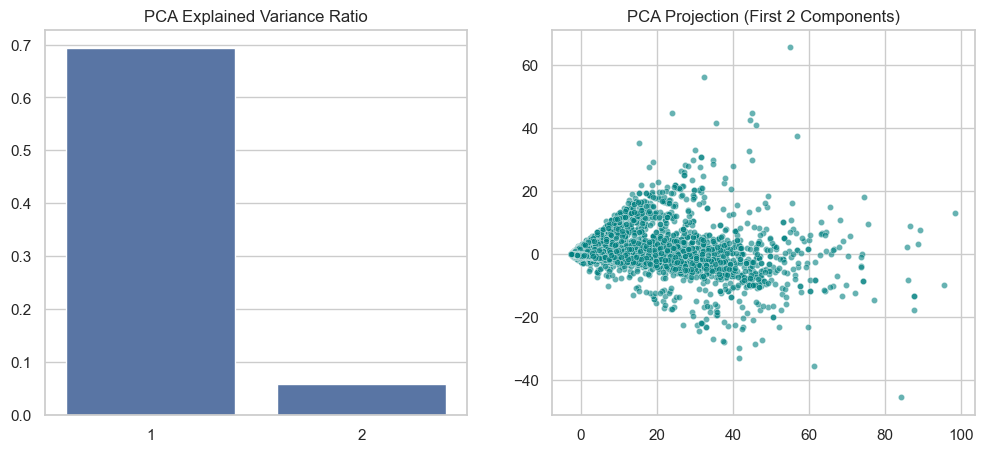


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 54392
Original Index Label: 56153
PC1 Value: 98.45
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
ee_003    31.957787
bi_000    28.128954
ba_001    27.427206
cn_003    26.412222
ee_004    24.690409
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


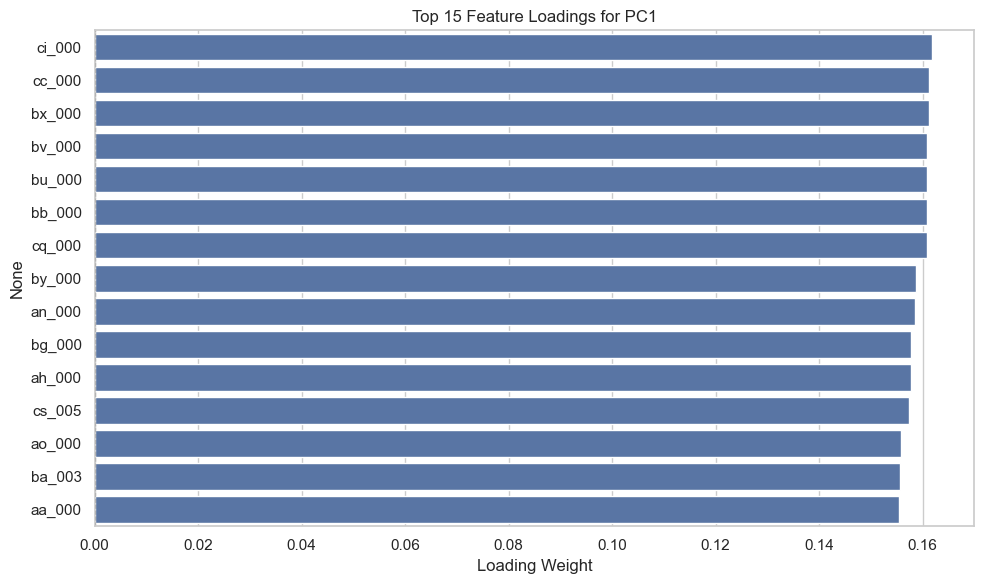


--- Correlation Heatmap (Top 50 Features) ---


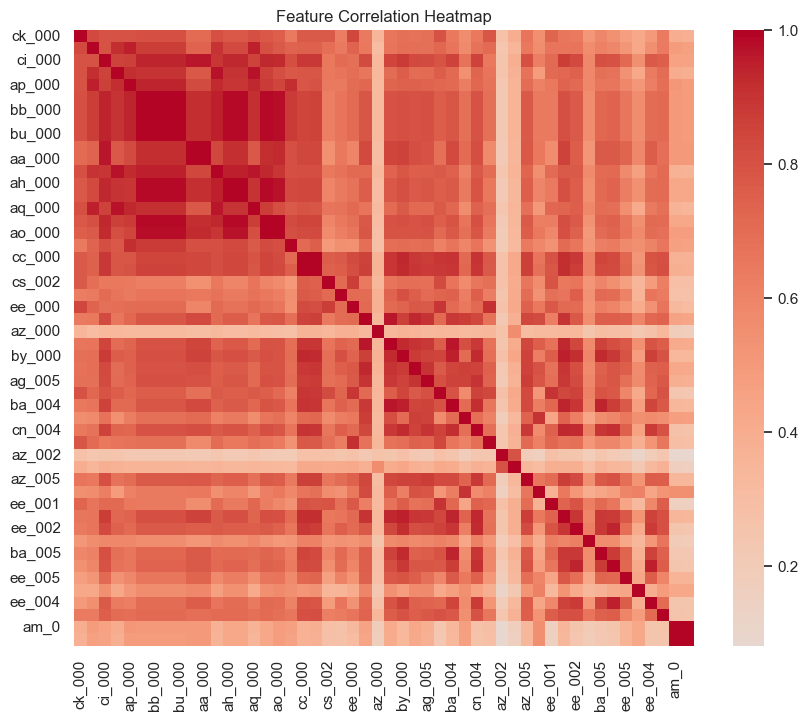


--- Feature Distributions (Top 3 Selected Features) ---
Feature 'ck_000', Class 1 → Mean: 8452585.2779, Std: 6518341.7733
Feature 'ck_000', Class 0 → Mean: 580426.6594, Std: 1733614.4921


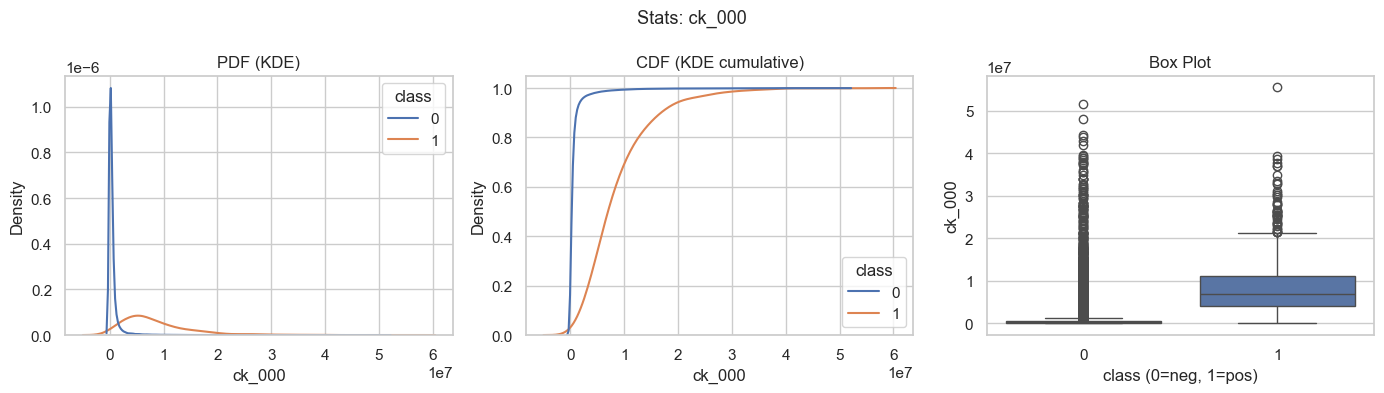

****************************************************************************************************
Feature 'bj_000', Class 1 → Mean: 7857091.0161, Std: 6820064.2473
Feature 'bj_000', Class 0 → Mean: 384869.4594, Std: 1279047.6474


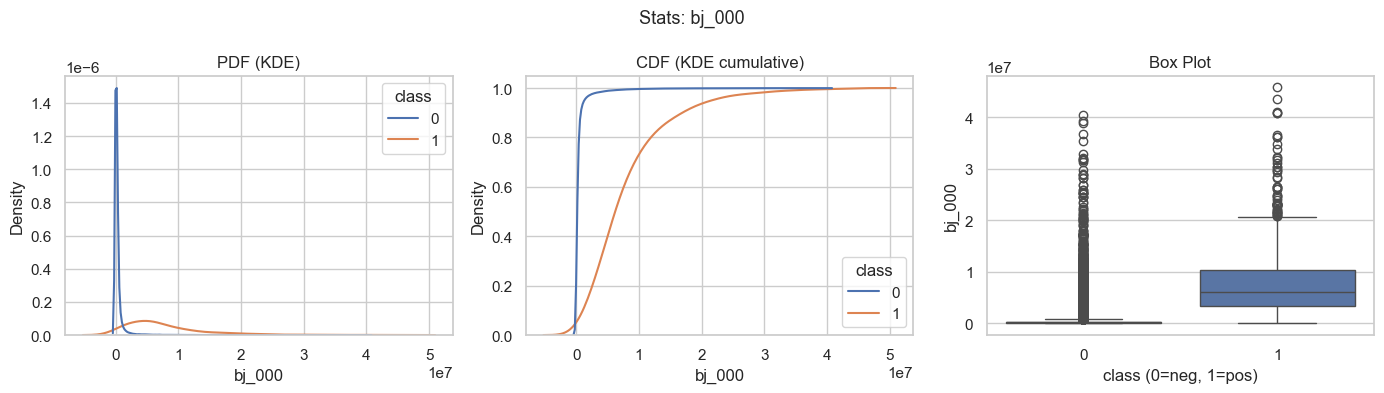

****************************************************************************************************
Feature 'ci_000', Class 1 → Mean: 38989309.8623, Std: 23811706.3385
Feature 'ci_000', Class 0 → Mean: 2883076.8585, Std: 6300749.3423


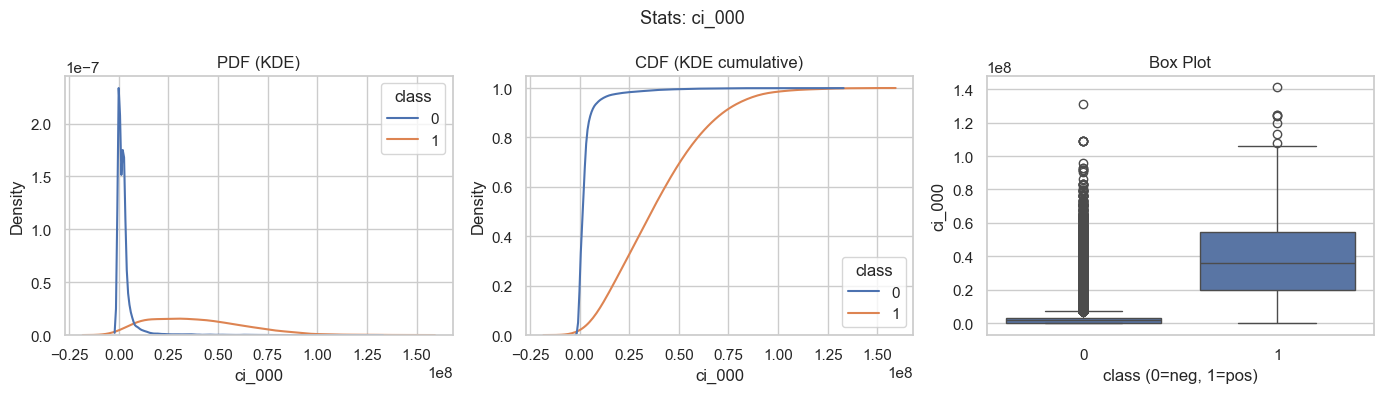

****************************************************************************************************


In [ ]:
from sklearn.preprocessing import StandardScaler

# Quick imputation for visualization purposes (using the project's preprocessor)
print("Preparing data for visualization...")
preproc_viz = ScaniaPreprocessor()
X_clean = preproc_viz.fit_transform(X_train_raw)

# Scale the data (Critical for PCA)
print("Scaling data...")
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_clean)
X_viz = pd.DataFrame(X_scaled_np, columns=X_clean.columns, index=X_clean.index)

# --- Feature Selection for EDA ---
# Select top 50 features using Mutual Information for focused analysis
# We use X_viz (preprocessed & scaled) to ensure we only select features that were not dropped
print("Selecting top 50 features via K-S for EDA...")
top_features_eda = select_features_ks(X_viz, y_train_raw, p_value_threshold=0.05, top_n_by_stat=50)
X_viz_selected = X_viz[top_features_eda]

# 1. PCA Analysis (on selected features)
print(f"\n--- PCA Analysis (Top {len(top_features_eda)} Features) ---")
pca_df = pca_inspect(X_viz_selected)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_selected.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_selected.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_selected, component_idx=0)

# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {len(top_features_eda)} Features) ---")
plot_correlation_heatmap(X_viz_selected) 

# 3. Feature Distributions (EDA with Stats)
print(f"\n--- Feature Distributions (Top 3 Selected Features) ---")
# Combine X and y temporarily for plotting
# Note: We use X_train_raw for the stats plot to show original values, not scaled ones
df_viz = X_train_raw[top_features_eda].copy()
df_viz['class'] = y_train_raw

# Visualize the top 3 features from the selection
eda_plots_with_stats(df_viz[top_features_eda[:3] + ['class']], title_prefix="Stats: ")

## 5. Feature Engineering & Selection Strategy
We compare three distinct feature sets to test different hypotheses:
1. **K-S Selected:** Features with the largest distribution shift between Healthy and Failed (Univariate).
2. **Mutual Information:** Features with the highest non-linear dependency with the target.
3. **Engineered:** Statistical moments replacing raw histogram bins.

In [6]:
# 1. K-S Selection
print("--- Computing K-S Feature Set ---")
selected_features_ks = select_features_ks(X_train_raw, y_train_raw, top_n_by_stat=100, p_value_threshold=0.05)
X_train_ks = X_train_raw[selected_features_ks]
X_test_ks = X_test_raw[selected_features_ks]
print(f"K-S Train Shape: {X_train_ks.shape}")

# 2. Mutual Information Selection
print("\n--- Computing Mutual Information Feature Set ---")
selected_features_mi = select_features_mutual_info(X_train_raw, y_train_raw, top_n=100)
X_train_mi = X_train_raw[selected_features_mi]
X_test_mi = X_test_raw[selected_features_mi]
print(f"MI Train Shape: {X_train_mi.shape}")

# 3. Feature Engineering
print("\n--- Computing Engineered Feature Set ---")
X_train_eng = create_engineered_feature_set(X_train_raw)
X_test_eng = create_engineered_feature_set(X_test_raw)
print(f"Engineered Train Shape: {X_train_eng.shape}")

--- Computing K-S Feature Set ---
Starting K-S test on 170 features...
K-S Train Shape: (58126, 100)

--- Computing Mutual Information Feature Set ---
Calculating Mutual Information...
Selected top 100 features by Mutual Information.
MI Train Shape: (58126, 100)

--- Computing Engineered Feature Set ---
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135
Engineered Train Shape: (58126, 135)


In [7]:
# Check how many features are selected by K-S and Mutual Information and how many overlap
print(f"K-S Selected Features: {len(selected_features_ks)}")
print(f"Mutual Information Selected Features: {len(selected_features_mi)}")
print(f"Overlap: {len(set(selected_features_ks).intersection(set(selected_features_mi)))}")

# Select the set of features that are selected by K-S + Mutual Information (we use set to handle overlapped features)
selected_features = list(set(selected_features_ks).union(set(selected_features_mi)))

# Select the features from the training and test sets
X_train_ks_mi = X_train_raw[selected_features]
X_test_ks_mi = X_test_raw[selected_features]
print(f"K-S + MI Train Shape: {X_train_ks_mi.shape}")


K-S Selected Features: 100
Mutual Information Selected Features: 100
Overlap: 89
K-S + MI Train Shape: (58126, 111)


## 6. Model Experimentation Grid
We run a comprehensive grid search over Models, Feature Sets, and Sampling Strategies.
**Metric:** Total Cost (FP=10, FN=500).

In [8]:
# Define Feature Sets
FEATURE_SETS = {
    "K-S Selected": (X_train_ks, X_test_ks),
    "Mutual Information": (X_train_mi, X_test_mi),
    "K-S + MI": (X_train_ks_mi, X_test_ks_mi),
    # "Engineered": (X_train_eng, X_test_eng) # Uncomment to include (slower)
}

# Define Models
MODELS = get_models(random_state=42)

# Define Samplers
SAMPLERS = {
    "No Sampling": None,
    "SMOTE": "smote",
    "Gaussian Copula": "copula" # Uncomment to include
}

# Define Sampling Percentages
SAMPLING_PCTS = [0.25, 0.5]

# Define Tuning Strategies
TUNING = {
    "Tuned Threshold": True,
    # "Fixed 0.5": False
}

# Run the Grid
results_df = run_experiment_grid(
    models=MODELS,
    feature_sets=FEATURE_SETS,
    samplers=SAMPLERS,
    tuning_strategies=TUNING,
    sampling_percentages=SAMPLING_PCTS,
    y_train=y_train_raw,
    n_cv_splits=5, # Reduced for speed in demo
    verbose=True
)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM | K-S Selected | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.727 | Cost 7024±665 | thr(median) 0.003076173088229483 | fit 8.36s | pred 0.06s

RUNNING: LightGBM | K-S Selected | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.989±0.005 | Macro-F1 0.758 | Cost 6910±710 | thr(median) 0.026990430341806 | fit 7.25s | pred 0.08s

RUNNING: LightGBM | K-S Selected | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.729 | Cost 7474±952 | thr(median) 0.02074317074112377 | fit 9.97s | pred 0.04s

RUNNING: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 57197
AUC 0.988±0.005 | Macro-F1 0.739 | Cost 6962±1289 | thr(median) 0.007741925573192631 | fit 12.07s | pred 0.03s

RUNNING: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
AUC 0.989±0.005 | Macro-F1 0.737 | Cost 6632±1311 | thr(median) 0.01091945090283531 | fit 15.60s | pred 0.02s

RUNNING: LightGBM | Mutual Information | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.777 | Cost 7188±753 | thr(median) 0.006401253429846679 | fit 5.58s | pred 0.02s

RUNNING: LightGBM | Mutual Information | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.743 | Cost 7028±826 | thr(median) 0.026306715618856728 | fit 5.41s | pred 0.06s

RUNNING: LightGBM | Mutual Information | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.744 | Cost 7526±1168 | thr(median) 0.033706824465151095 | fit 7.65s | pred 0.02s

RUNNING: LightGBM | Mutual Information | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
AUC 0.989±0.005 | Macro-F1 0.745 | Cost 6934±1089 | thr(median) 0.010191920204077973 | fit 11.86s | pred 0.02s

RUNNING: LightGBM | Mutual Information | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
AUC 0.987±0.006 | Macro-F1 0.738 | Cost 7072±1453 | thr(median) 0.01163406164534202 | fit 13.50s | pred 0.01s

RUNNING: LightGBM | K-S + MI | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.987±0.005 | Macro-F1 0.760 | Cost 7272±768 | thr(median) 0.004854915586419537 | fit 7.59s | pred 0.02s

RUNNING: LightGBM | K-S + MI | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.732 | Cost 6948±1297 | thr(median) 0.014388575051232312 | fit 9.56s | pred 0.06s

RUNNING: LightGBM | K-S + MI | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


AUC 0.988±0.005 | Macro-F1 0.732 | Cost 7436±1261 | thr(median) 0.021249220925704276 | fit 10.13s | pred 0.03s

RUNNING: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing: 744 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10695 samples...
Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
Balancing complete. New dataset size: 57197
Balancing complete. New dataset size: 57196
AUC 0.989±0.005 | Macro-F1 0.732 | Cost 6588±838 | thr(median) 0.008891744236932585 | fit 15.06s | pred 0.02s

RUNNING: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 744 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22134 samples...
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
Balancing complete. New dataset size: 68637
Balancing complete. New dataset size: 68635
AUC 0.988±0.005 | Macro-F1 0.727 | Cost 6498±1266 | thr(median) 0.008049462786938005 | fit 18.94s | pred 0.02s

--- EXPERIMENT MATRIX COMPLETE ---


## 7. Experiment Results & Best Model Selection

,model,feature_set,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage
14,LightGBM,K-S + MI,Gaussian Copula,Tuned Threshold,6498.0,1266.260637,0.988068,0.726530,18.935490,LightGBM | K-S + MI | Gaussian Copula | Tuned ...,0.50
13,LightGBM,K-S + MI,Gaussian Copula,Tuned Threshold,6588.0,837.529701,0.988559,0.731501,15.061770,LightGBM | K-S + MI | Gaussian Copula | Tuned ...,0.25
4,LightGBM,K-S Selected,Gaussian Copula,Tuned Threshold,6632.0,1310.731094,0.988578,0.737201,15.596022,LightGBM | K-S Selected | Gaussian Copula | Tu...,0.50
1,LightGBM,K-S Selected,SMOTE,Tuned Threshold,6910.0,709.845054,0.989081,0.758213,7.252580,LightGBM | K-S Selected | SMOTE | Tuned Thresh...,0.25
8,LightGBM,Mutual Information,Gaussian Copula,Tuned Threshold,6934.0,1089.175835,0.988572,0.745176,11.861321,LightGBM | Mutual Information | Gaussian Copul...,0.25
11,LightGBM,K-S + MI,SMOTE,Tuned Threshold,6948.0,1297.249398,0.988044,0.732097,9.555596,LightGBM | K-S + MI | SMOTE | Tuned Threshold ...,0.25
3,LightGBM,K-S Selected,Gaussian Copula,Tuned Threshold,6962.0,1289.486720,0.988329,0.738597,12.070255,LightGBM | K-S Selected | Gaussian Copula | Tu...,0.25
0,LightGBM,K-S Selected,No Sampling,Tuned Threshold,7024.0,664.788688,0.987872,0.727396,8.361149,LightGBM | K-S Selected | No Sampling | Tuned ...,NaN
6,LightGBM,Mutual Information,SMOTE,Tuned Threshold,7028.0,825.624612,0.988347,0.742671,5.410598,LightGBM | Mutual Information | SMOTE | Tuned ...,0.25
9,LightGBM,Mutual Information,Gaussian Copula,Tuned Threshold,7072.0,1452.658253,0.987353,0.738307,13.496721,LightGBM | Mutual Information | Gaussian Copul...,0.50


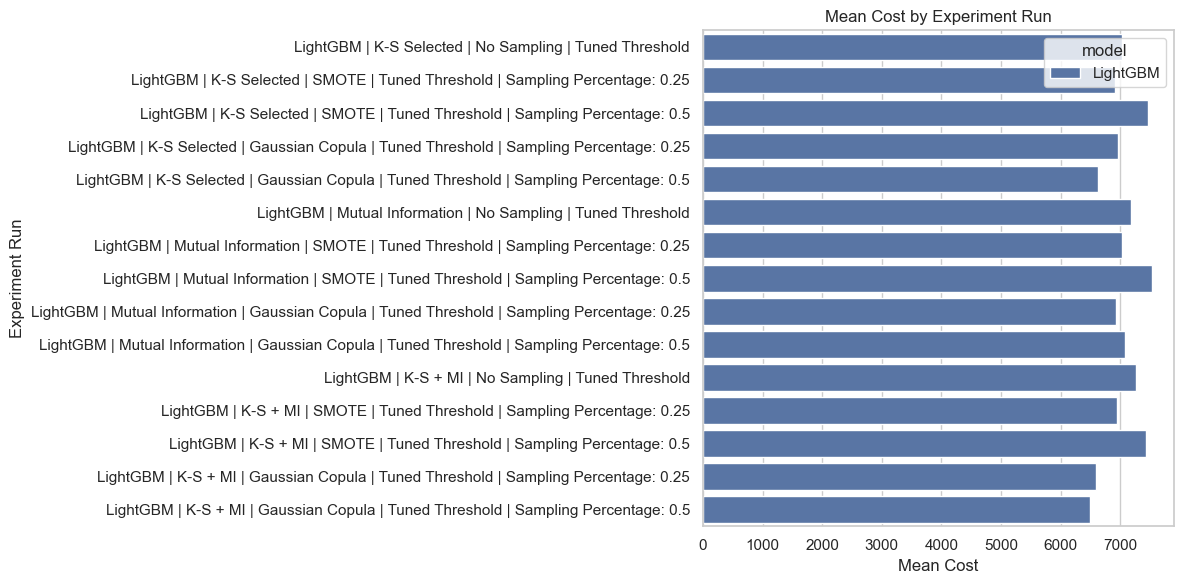

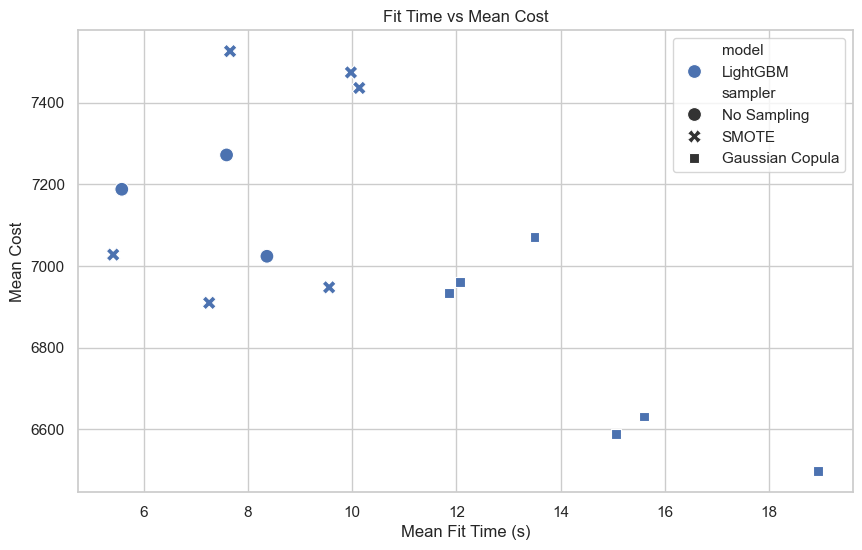

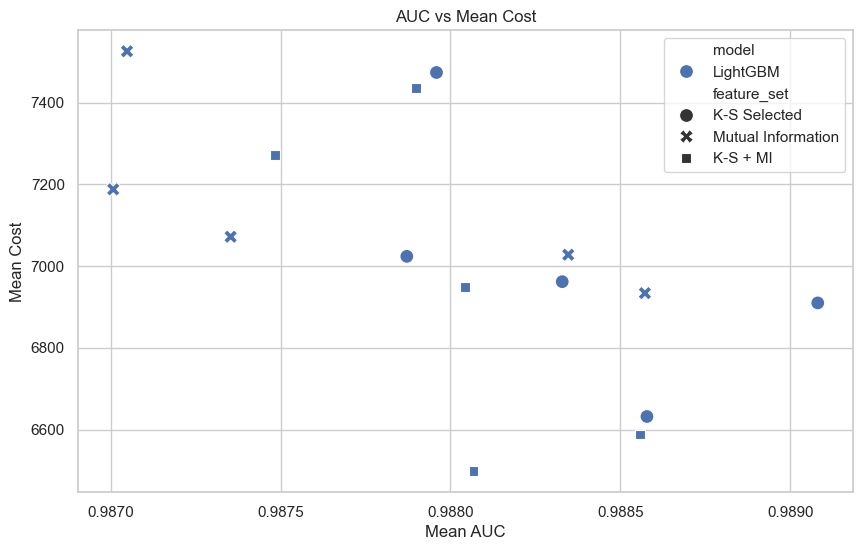

In [9]:
# Display Top Results
display(results_df.sort_values(by='cost_mean').head(10))

# Visualize Results
plot_experiment_results(results_df)

No: 1 Run: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...
Balancing complete. New dataset size: 68635
Threshold tuned in 14.37s -> thr=0.010 (Val Cost=5620)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Balancing: 929 minority, 57197 majority.
Target ratio: 0.5 -> Target minority count: 28598
Synthesizing 27669 samples...
Balancing complete. New dataset size: 85795
Test → AUC=0.992 | F1=0.784 | Cost=10070 | Recall=0.973 | Precision=0.419 | fit=17.03s | pred=0.04s | thr=0.010
Test CM (thr=0.010): FP=507, FN=10


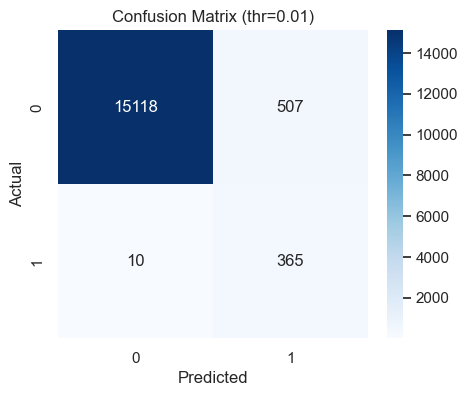

No: 2 Run: LightGBM | K-S + MI | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45757 majority.
Target ratio: 0.25 -> Target minority count: 11439
Synthesizing 10696 samples...
Balancing complete. New dataset size: 57196
Threshold tuned in 11.96s -> thr=0.007 (Val Cost=6480)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Balancing: 929 minority, 57197 majority.
Target ratio: 0.25 -> Target minority count: 14299
Synthesizing 13370 samples...
Balancing complete. New dataset size: 71496
Test → AUC=0.988 | F1=0.738 | Cost=10770 | Recall=0.981 | Precision=0.336 | fit=12.24s | pred=0.02s | thr=0.007
Test CM (thr=0.007): FP=727, FN=7


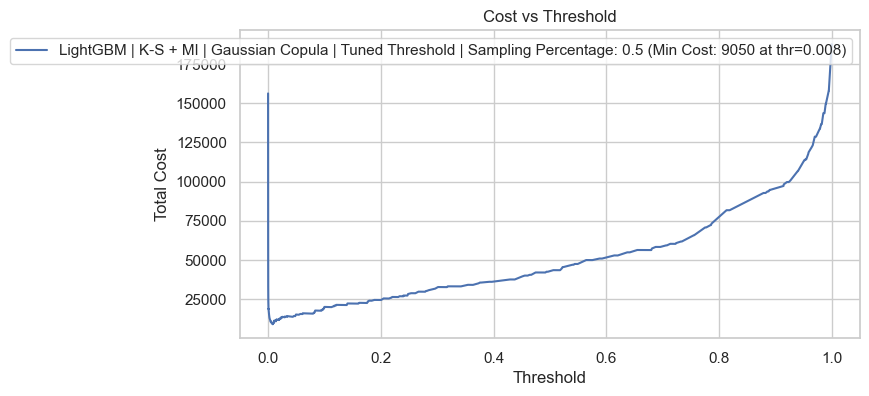

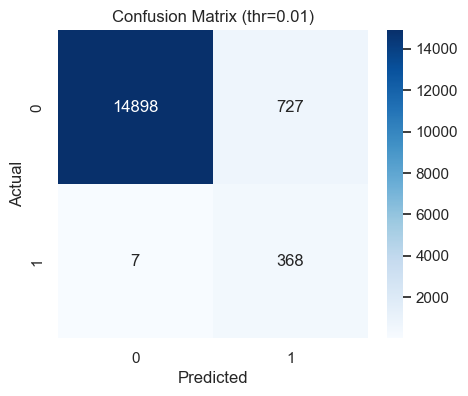

No: 3 Run: LightGBM | K-S Selected | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45757 majority.
Target ratio: 0.5 -> Target minority count: 22878
Synthesizing 22135 samples...
Balancing complete. New dataset size: 68635
Threshold tuned in 10.32s -> thr=0.007 (Val Cost=6390)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Balancing: 929 minority, 57197 majority.
Target ratio: 0.5 -> Target minority count: 28598
Synthesizing 27669 samples...
Balancing complete. New dataset size: 85795
Test → AUC=0.995 | F1=0.761 | Cost=10570 | Recall=0.976 | Precision=0.376 | fit=13.56s | pred=0.03s | thr=0.007
Test CM (thr=0.007): FP=607, FN=9


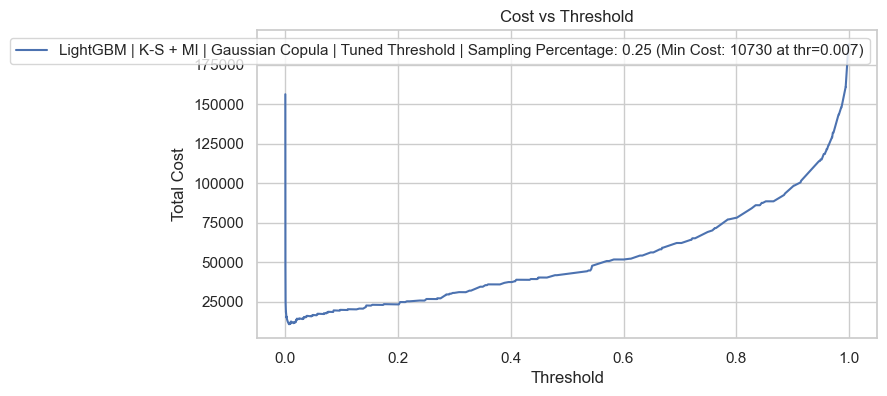

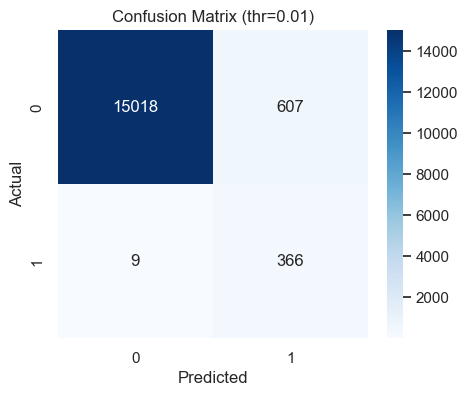

In [10]:
for i in range(3):
    if not results_df.empty:
        best_run = results_df.sort_values(by='cost_mean').iloc[i]
        print(f"No: {i+1} Run: {best_run['run_name']}")
        
        # Reconstruct the best configuration
        best_model_name = best_run['model']
        best_fset_name = best_run['feature_set']
        best_sampler_name = best_run['sampler']
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        # Get Data
        X_tr_best, X_te_best = FEATURE_SETS[best_fset_name]
        
        # Get Model
        model = MODELS[best_model_name]
        
        # Get Sampler Key
        sampler_key = SAMPLERS[best_sampler_name]
        
        # Evaluate on Test
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr_best,
            y_train=y_train_raw,
            X_test=X_te_best,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=True
        )
        
        # Plot Deep Dive Visuals
        probs = test_results['test_probabilities']
        plot_confusion(y_test_raw, probs, threshold=test_results['metrics']['Threshold'])
        plot_cost_threshold_curve(y_test_raw, probs, label=best_run['run_name'])

## 8. Root Cause Analysis (RCA): The Grand Unification

**Objective:** Determine the true causal drivers of failure.
**Method:** We combine three perspectives (excluding MI due to stability issues):
1.  **K-S Test:** Distribution Shift (General Health).
2.  **SHAP:** Interaction Effects (Complex Failure Modes).
3.  **Lasso (L1):** Linear Separability (Deterministic Triggers).

We feed the union of these top features into a **Sparse Causal Bayesian Network (PyMC)** with Laplace priors to find the survivors.

In [ ]:
# --- RCA: Imports & Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
import pymc as pm
import arviz as az
import sys
import os

# Statistical Imports
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import shap
from scipy.stats import ks_2samp
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Causal Imports (Critical Check)
try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.cit import chisq
    from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
    from causallearn.search.FCMBased.lingam import DirectLiNGAM
    from causallearn.graph.GraphNode import GraphNode
    print("✅ causal-learn library loaded successfully.")
except ImportError:
    print("❌ CRITICAL: causal-learn not found. Please run: !pip install causal-learn")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Project Imports (Assuming you are in the notebooks root)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from challenge.data.ingest import load_data
from challenge.data.feature_selection import select_features_ks

In [3]:
def load_and_prep_data():
    print("--- [1] Data Engineering ---")
    X_raw, y_raw = load_data('dataset/', 'aps_failure_training_set.csv')
    
    # 1. Row Cleaning (Low NA)
    na_pct = X_raw.isna().mean()
    low_na_cols = na_pct[(na_pct > 0) & (na_pct <= 0.04)].index
    if not low_na_cols.empty:
        rows_to_drop = X_raw[low_na_cols].isna().any(axis=1)
        indices_to_drop = X_raw[rows_to_drop].index
        X_raw = X_raw.drop(index=indices_to_drop)
        y_raw = y_raw.drop(index=indices_to_drop)
        
    # 2. Drop Outlier
    if 20683 in X_raw.index:
        X_raw = X_raw.drop(index=20683)
        y_raw = y_raw.drop(index=20683)
    
    # 3. Robust Imputation (Missingness Flags)
    X_clean = X_raw.copy()
    missing_cols = [c for c in X_clean.columns if X_clean[c].isnull().mean() >= 0.05]
    for col in missing_cols:
        X_clean[f'{col}_is_missing'] = X_clean[col].isnull().astype(int)
        
    imputer = SimpleImputer(strategy='median')
    X_clean_imp = pd.DataFrame(imputer.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)
    
    # 4. Remove constant columns
    X_clean_imp = X_clean_imp.loc[:, X_clean_imp.nunique() > 1]
    
    return X_clean_imp, y_raw

In [4]:
X_clean, y_raw = load_and_prep_data()
n_features = 12
final_features, ks_f, shap_f, lasso_f = get_consensus_features(X_clean, y_raw, n_features=n_features)

# --- Skewness Correction (Log Transform) ---
print("\n--- Checking for Skewness ---")
# Always transform cn_001 if present
skewed_candidates = set(final_features)

if 'cn_001' in X_clean.columns: skewed_candidates.add('cn_001')
for col in skewed_candidates:
    if col not in X_clean.columns: continue
        
    skew_val = X_clean[col].skew()
    max_val = X_clean[col].max()
        
    # Transform if explicitly requested (cn_001) or highly skewed
    if col == 'cn_001' or (abs(skew_val) > 2 and max_val > 100):
        print(f"  Applying Log1p to {col} (Skew: {skew_val:.2f}, Max: {max_val})")
        X_clean[col] = np.log1p(X_clean[col])

--- [1] Data Engineering ---
Successfully loaded and processed aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)

--- [2] Consensus Feature Selection (Top 12 per method) ---
Starting K-S test on 208 features...
Starting K-S test on 208 features...
Calculating SHAP importance...
Calculating Lasso features...
Pooled Candidates: 30
Final Representatives after Clustering: 10

--- Checking for Skewness ---
  Applying Log1p to ag_009 (Skew: 86.59, Max: 18336298.0)
  Applying Log1p to dg_000 (Skew: 67.62, Max: 20880422.0)
  Applying Log1p to az_006 (Skew: 23.67, Max: 64589140.0)
  Applying Log1p to cn_001 (Skew: 27.99, Max: 14451842.0)
  Applying Log1p to ay_000 (Skew: 65.06, Max: 50553892.0)
  Applying Log1p to ck_000 (Skew: 8.89, Max: 55428669.12)
  Applying Log1p to br_000 (Skew: 3.10, Max: 1310700.0)
  Applying Log1p to bk_000 (Skew: 4.28, Max: 1310700.0)
  Applying Log1p to ba_008 (Skew: 55.85, Max: 31265984.0)


In [6]:
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)

In [7]:
# 2. Engine A: PC Algorithm (Discrete + Constraints)
adj_pc, lbl_pc = run_pc_algorithm(X_clean, y_raw, final_features)
print("\n--- Analyzing PC Structure ---")
roots_pc, meds_pc, pars_pc, G_pc = analyze_graph_structure(adj_pc, lbl_pc, force_target_sink=False)

# 3. Engine B: DirectLiNGAM (Continuous + Physics Fix)
adj_lin, lbl_lin = run_lingam_algorithm(X_cont, y_raw, final_features)
print("\n--- Analyzing LiNGAM Structure (With Physics Fix) ---")
roots_lin, meds_lin, pars_lin, G_lin = analyze_graph_structure(adj_lin, lbl_lin, force_target_sink=True)

print("Structure Learning Complete.")
print(f"LiNGAM Roots Identified: {roots_lin}")


--- [Engine A] PC Algorithm ---


  0%|          | 0/11 [00:00<?, ?it/s]


--- Analyzing PC Structure ---

--- [Engine B] DirectLiNGAM ---

--- Analyzing LiNGAM Structure (With Physics Fix) ---
  [Physics Constraint] Flipped edge: dg_000 -> class
  [Physics Constraint] Flipped edge: ay_000 -> class
Structure Learning Complete.
LiNGAM Roots Identified: ['ck_000']


In [8]:
# 6. Bayesian Stats
results = []
    
    # LiNGAM (Primary)
summ, feats = run_pymc(X_cont, y_raw, roots_lin, "LiNGAM Roots")
if summ is not None:
    for i, f in enumerate(feats):
        mean_val = summ.iloc[i]['mean']
        results.append({'Algo': 'LiNGAM', 'Role': 'Root', 'Feature': f, 
                        'Mean': mean_val, 'Odds_Ratio': np.exp(mean_val)})
    
    # PC (Comparison)
summ, feats = run_pymc(X_cont, y_raw, roots_pc, "PC Roots")
if summ is not None:
    for i, f in enumerate(feats):
        mean_val = summ.iloc[i]['mean']
        results.append({'Algo': 'PC', 'Role': 'Root', 'Feature': f, 
                        'Mean': mean_val, 'Odds_Ratio': np.exp(mean_val)})


Running PyMC for LiNGAM Roots on ['ck_000']...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 69 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Running PyMC for PC Roots on ['ba_008']...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## 9. Visualizing the Causal Structure
We visualize the relationships between the Top Survivors and the Failure outcome using a **Causal Network Graph** and **SHAP Interaction Plots**.

In [9]:
df_res = pd.DataFrame(results)
    
# Create output directory
output_dir = "rca_results"
os.makedirs(output_dir, exist_ok=True)
    
# Pass DataFrame for coloring
visualize_hierarchy_final(G_lin, "LiNGAM Causal Hierarchy (Final)", f"{output_dir}/rca_lingam_optimized_n_features={n_features}.png", df_res)
visualize_hierarchy_final(G_pc, "PC Causal Hierarchy (Final)", f"{output_dir}/rca_pc_optimized_n_features={n_features}.png", df_res)
    

Saved High-Res rca_results/rca_lingam_optimized_n_features=12.png
Saved High-Res rca_results/rca_pc_optimized_n_features=12.png


In [10]:
print("\n--- Exporting Graph Data ---")
# 1. Edges
edges_data = []
for u, v in G_pc.edges(): edges_data.append({'Algo': 'PC', 'Source': u, 'Target': v})
for u, v in G_lin.edges(): edges_data.append({'Algo': 'LiNGAM', 'Source': u, 'Target': v})
pd.DataFrame(edges_data).to_csv(f"{output_dir}/rca_edges_n_features={n_features}.csv", index=False)
print(f"Saved {output_dir}/rca_edges_n_features={n_features}.csv")
    
# 2. Nodes (with Roles & Stats)
nodes_data = []
    
def process_nodes(G, algo, roots, meds, pars, pymc_df):
    for n in G.nodes():
        role = 'Unconnected'
        if n == 'class': role = 'Target'
        elif n in roots: role = 'Root'
        elif n in meds: role = 'Mediator'
        elif n in pars: role = 'Direct Parent' # Note: Parents can also be Roots or Mediators, strict hierarchy might vary
            
        # Refine Role Priority
        if n == 'class': role = 'Target'
        elif n in roots: role = 'Root'
        elif n in meds: role = 'Mediator'
            
        stats = {}
        if not pymc_df.empty:
            row = pymc_df[(pymc_df['Algo'] == algo) & (pymc_df['Feature'] == n)]
            if not row.empty:
                stats = row.iloc[0].to_dict()
            
        nodes_data.append({
            'Algo': algo,
            'Node': n,
            'Role': role,
            'PyMC_Mean': stats.get('Mean', np.nan),
            'PyMC_Odds_Ratio': stats.get('Odds_Ratio', np.nan)
            })

process_nodes(G_pc, 'PC', roots_pc, meds_pc, pars_pc, df_res)
process_nodes(G_lin, 'LiNGAM', roots_lin, meds_lin, pars_lin, df_res)
    
pd.DataFrame(nodes_data).to_csv(f"{output_dir}/rca_node_details_n_features={n_features}.csv", index=False)
print(f"Saved {output_dir}/rca_node_details_n_features={n_features}.csv")

df_res.to_csv(f"{output_dir}/rca_final_optimized_results_n_features={n_features}.csv", index=False)
print("\n--- OPTIMIZED RCA RESULTS ---")
if not df_res.empty:
    print(df_res.sort_values('Odds_Ratio', ascending=False))
else:
    print("No significant results found.")




--- Exporting Graph Data ---
Saved rca_results/rca_edges_n_features=12.csv
Saved rca_results/rca_node_details_n_features=12.csv

--- OPTIMIZED RCA RESULTS ---
     Algo  Role Feature   Mean  Odds_Ratio
0  LiNGAM  Root  ck_000  3.555   34.987820
1      PC  Root  ba_008  1.454    4.280201
